In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
batch = 256
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


mnist_indice = torch.randperm(len(mnist))
mnist_train_sampler = RandomSampler(mnist_indice[:int(len(mnist) * 0.9)])
mnist_valid_sampler = RandomSampler(mnist_indice[int(len(mnist) * 0.9):])


mnist_train_dataloader = DataLoader(mnist, sampler=mnist_train_sampler, batch_size=batch)
mnist_val_dataloader = DataLoader(mnist, sampler=mnist_valid_sampler, batch_size=batch)

# for x, y in mnist_train_dataloader:
#     print(x[1])
#     print(y[1])
#     break
# for x, y in mnist_val_dataloader:
#     print(x[1])
#     print(y[1])
#     break

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.output = nn.Sequential(nn.Linear(100, 256),#雜訊是長度100的tensor
                                    nn.LeakyReLU(),
                                    nn.Linear(256, 512),
                                    nn.LeakyReLU(),
                                    nn.Linear(512, 1024),
                                    nn.LeakyReLU(),
                                    nn.Linear(1024, 784),
                                    nn.Tanh())#輸出值域要藉於-1~1
    def forward(self, batch_size : int, use_gpu = False):
        x = torch.rand((batch_size, 100))
        if (use_gpu): 
            x = x.to(device="cuda", dtype=torch.float32)
        return self.output(x)
    def generate_image(self, num : int):
        image = self.forward(batch_size=num)
        image = image.view(-1, 28, 28).detach().numpy()
        image = (image + 1) * 255 / 2
        return image

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.output = nn.Sequential(nn.Linear(784, 1024),
                                    nn.LeakyReLU(),
                                    nn.Dropout(0.4),
                                    nn.Linear(1024, 512),
                                    nn.LeakyReLU(),
                                    nn.Dropout(0.3),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.LeakyReLU(),
                                    nn.Linear(256, 1),
                                    nn.Sigmoid()
                                    )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.output(x)

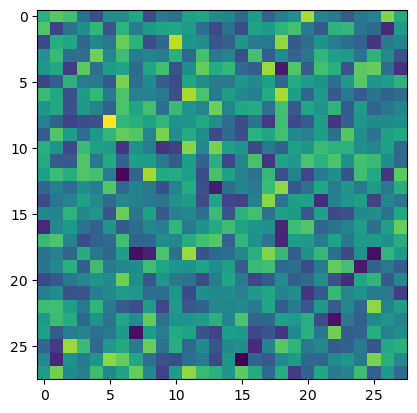

In [5]:
generator = Generator()
classifier = Classifier()


image = generator.generate_image(10)
plt.imshow(image[0])
plt.show()

In [6]:
#test classifier

def validate(classifier, loss_function, dataloader, use_gpu : bool):
    val_loss = 0
    acc = 0
    count = 0
    classifier.eval()
    with torch.no_grad():
        for x, y in dataloader:
            count += 1
            label = torch.ones(len(x))
            if (use_gpu):
                x = x.to(device="cuda", dtype=torch.float32)
                label = label.to(device="cuda", dtype=torch.float32)

            predict = classifier(x)
            label = label.view(predict.shape)
            loss = loss_function(predict, label)
            val_loss += loss
            acc += ((predict >= 0.5)).sum() / len(x)

    return val_loss / count, acc / count


In [7]:
use_gpu = torch.cuda.is_available()

epoch = 1000
lr = 0.0002
beta = (0.5, 0.999)

optim_G = optim.Adam(generator.parameters(), lr=lr, betas=beta)
optim_C = optim.Adam(classifier.parameters(), lr=lr, betas=beta)
loss_function = nn.BCELoss()

fake_label = torch.ones(2*batch)#整個在騙的標籤會一直用到

if (use_gpu):
    print("GPU")
    loss_function = loss_function.to(device="cuda", dtype=torch.float32)
    #generator = generator.to(device="cuda", dtype=torch.float32)
    classifier = classifier.to(device="cuda", dtype=torch.float32)
    fake_label = fake_label.to(device="cuda", dtype=torch.float32)

GPU


epoch: 1:
classifier train loss: 0.019198379778560804, val loss: 0.0034183640964329243, val acc: 1.0
save model
generator loss: 0.19636599089513146
epoch: 2:
classifier train loss: 0.01663493338397684, val loss: 0.0023699419107288122, val acc: 1.0
save model
generator loss: 0.07170633153601035
epoch: 3:
classifier train loss: 0.030756517717654402, val loss: 0.002065084408968687, val acc: 1.0
save model
generator loss: 0.04006871583929132
epoch: 4:
classifier train loss: 0.04452443910921191, val loss: 0.001964062685146928, val acc: 1.0
save model
generator loss: 0.03963957144222421
epoch: 5:
classifier train loss: 0.05689348022532748, val loss: 0.0015977348666638136, val acc: 1.0
save model
generator loss: 0.03722705139827783
epoch: 6:
classifier train loss: 0.07897094160793944, val loss: 0.0018137007718905807, val acc: 1.0
generator loss: 0.028711207868113986
epoch: 7:
classifier train loss: 0.03832805244390793, val loss: 0.0021103485487401485, val acc: 1.0
generator loss: 0.0338600002

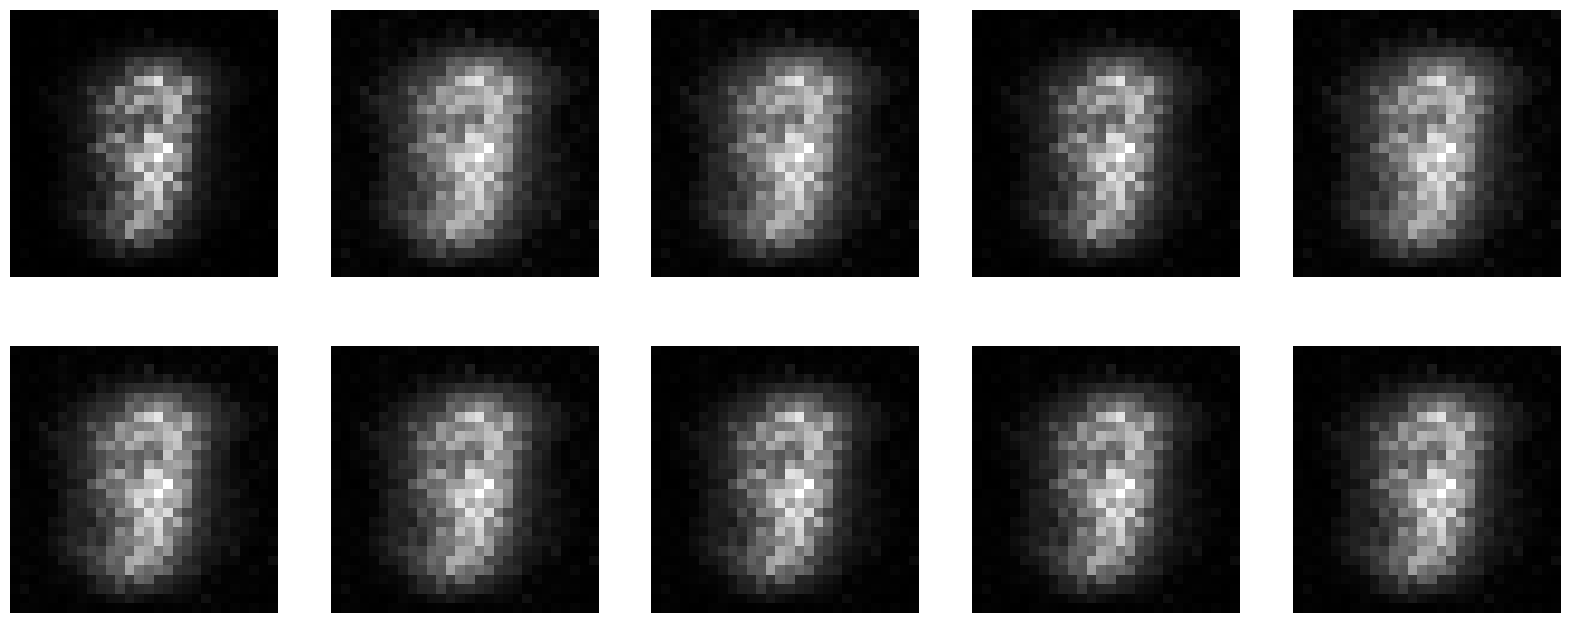

epoch: 26:
classifier train loss: 0.009312969887817397, val loss: 0.00045369932195171714, val acc: 1.0
generator loss: 0.029838191692226942
epoch: 27:
classifier train loss: 0.006476580549497157, val loss: 0.0008201700402423739, val acc: 0.9998372793197632
redo model
generator loss: 0.03341889915135788
epoch: 28:
classifier train loss: 0.011603285160728116, val loss: 0.0005134106613695621, val acc: 1.0
generator loss: 0.03195523865108547
epoch: 29:
classifier train loss: 0.003498630345665275, val loss: 0.00010466304229339585, val acc: 1.0
save model
generator loss: 0.03273704962308291
epoch: 30:
classifier train loss: 0.008322496929805369, val loss: 0.00046129326801747084, val acc: 1.0
generator loss: 0.03503535290662338
epoch: 31:
classifier train loss: 0.005053768711451917, val loss: 0.0003801957645919174, val acc: 1.0
generator loss: 0.0623115699691667
epoch: 32:
generator loss: 4.795377373081097e-05
epoch: 33:
classifier train loss: 0.005385840597730922, val loss: 2.463125929352827

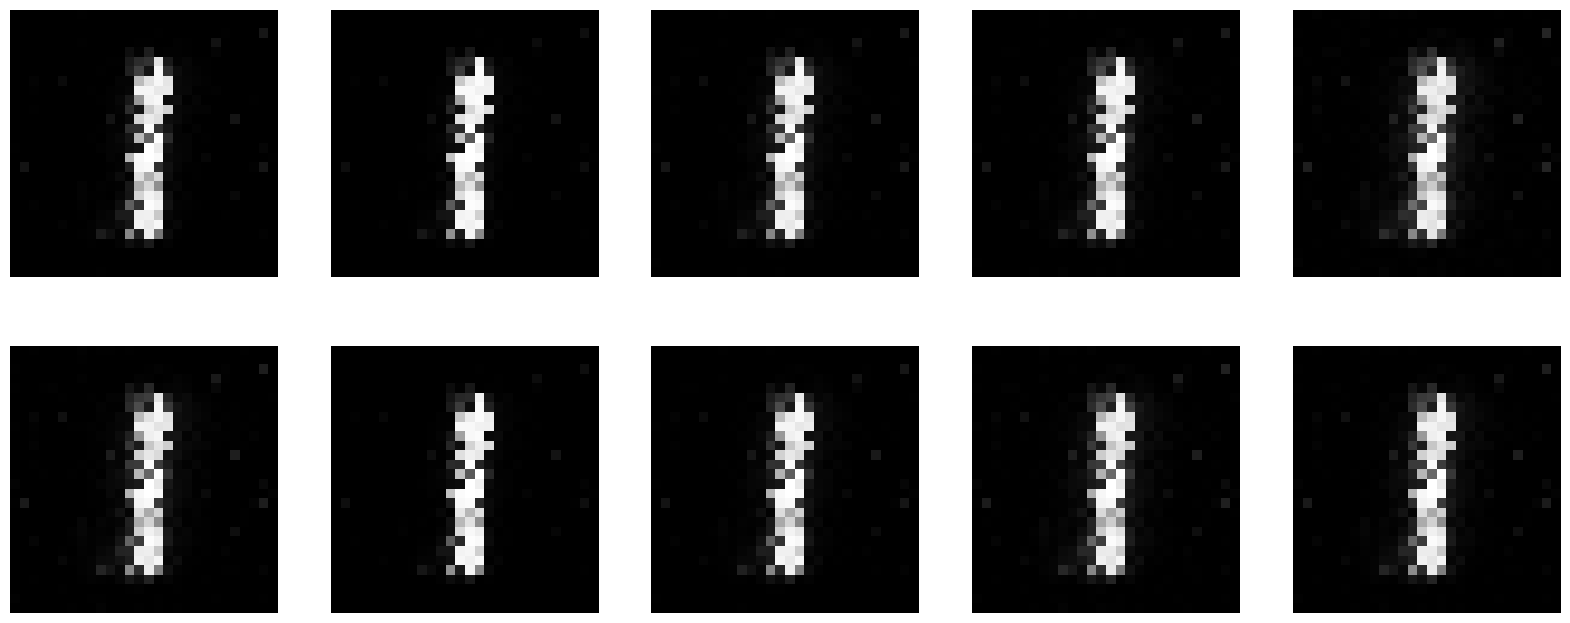

epoch: 51:
classifier train loss: 0.005415782825575467, val loss: 3.124825161648914e-05, val acc: 1.0
generator loss: 0.04221790974430754
epoch: 52:
classifier train loss: 0.004850015176046501, val loss: 2.2204729248187505e-05, val acc: 1.0
generator loss: 0.04152010401692755
epoch: 53:
classifier train loss: 0.008193269438801352, val loss: 0.00012254258035682142, val acc: 1.0
generator loss: 0.0392030056077195
epoch: 54:


In [8]:
classifier_loss = [1]
generator_loss = [0]
count = 235
min_val_loss = 1e9
max_val_acc = 0
for i in range(epoch):
    print(f"epoch: {i + 1}:")
    
    classifier_loss_epoch = 0
    generator_loss_epoch = 0
    
    classifier.train()

    if (i < 10 or generator_loss[len(generator_loss) - 1] < 0.05):
        for x, y in mnist_train_dataloader:
            optim_C.zero_grad()

            #reshape mnist data
            x = x.view(-1, 784)     
            #生成假資料
            with torch.no_grad(): fake_mnist = generator(batch_size=len(x))#不要被訓練到

            #合併資料
            train_data = torch.cat((x, fake_mnist))                        
            train_label = torch.cat((torch.ones(len(x)), torch.zeros(len(x))))

            #生成隨機排序
            random_indice = torch.randperm(2 * len(x))

            #隨機分布
            train_data = train_data[random_indice] 
            train_label = train_label[random_indice]

            
            if (use_gpu): 
                train_data = train_data.to(device="cuda", dtype=torch.float32)
                train_label = train_label.to(device="cuda", dtype=torch.float32)

            predict = classifier(train_data)

            train_label = train_label.view(predict.shape)

            #反向傳播
            c_loss = loss_function(predict, train_label)
            c_loss.backward()

            nn.utils.clip_grad_value_(classifier.parameters(), 3)

            optim_C.step()

            
            classifier_loss_epoch += c_loss.item()

        

        val_loss, val_acc = validate(classifier, loss_function, mnist_val_dataloader, use_gpu)
        print(f"classifier train loss: {classifier_loss_epoch / count}, val loss: {val_loss}, val acc: {val_acc}")


        #把最好的辨識器保存
        if (val_acc > max_val_acc or (val_acc == max_val_acc and val_loss < min_val_loss)):
            max_val_acc = val_acc
            min_val_loss = val_loss
            checkpoint = classifier.state_dict()
            torch.save(checkpoint, "classifier_checkpoint.pth")
            print("save model")
        #辨識器壞了，拿最好的重新開始
        elif (val_acc < max_val_acc):
            checkpoints = torch.load("classifier_checkpoint.pth")
            classifier.load_state_dict(checkpoint)
            print("redo model")


        classifier_loss.append(classifier_loss_epoch / count)


    #訓練生成器
    classifier.eval()
    
    if (use_gpu): generator = generator.to(device="cuda", dtype=torch.float32)
        
    for j in range(count):
        optim_G.zero_grad()

        fake_mnist = generator(batch_size=2*batch, use_gpu=use_gpu)
        
        predict = classifier(fake_mnist)

        fake_label = fake_label.view(predict.shape)
        #反向傳播
        g_loss = loss_function(predict, fake_label)
        g_loss.backward()
        optim_G.step()

        

        generator_loss_epoch += g_loss.item()

    if (use_gpu):generator = generator.to(device="cpu", dtype=torch.float32)
        
    
    
    print(f"generator loss: {generator_loss_epoch / count}")
    print("===========================================")
    generator_loss.append(generator_loss_epoch / count)

    torch.cuda.empty_cache()

    if (i % 25 == 24):
        fake_images = generator.generate_image(num=10)

        fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # 創建一個2x5的子圖網路

        for i, ax in enumerate(axs.flat):
            ax.imshow(fake_images[i], cmap='gray')  # 顯示圖片
            ax.axis('off')  # 關閉坐標軸

        plt.show()
